Notebook inspired from [This YouTube Tutorial](https://www.youtube.com/watch?v=68HR_eyzk00&list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE&index=2&t=51s&ab_channel=DigitalSreeni)

In [2]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import tensorflow as tf
import cv2
import os
import sys
import random
import numpy as np
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import tifffile as tif
from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, Dropout, concatenate, Flatten
from skimage.io import imread,imshow
from skimage.transform import resize
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import Model

In [2]:
def prep_image(image, crop_size, size_y, size_x):
    # Resize the image
    prepd_image = cv2.resize(image,(size_y, size_x))
    # Crop the image to remove the border black pixels
    prepd_image = prepd_image[crop_size:-crop_size, crop_size:-crop_size]
    return prepd_image

In [3]:
size_x=148
size_y=148
crop_size=10

In [4]:
################# Storing Train Images into an array #############
train_images=[]

for directory_path in glob.glob( 'Water Bodies Dataset/Images/'):
    for img_path in glob.glob(os.path.join(directory_path,"*.jpg")):
        #print(img_path)
        img=cv2.imread(img_path,cv2.IMREAD_COLOR)
        img=prep_image(img,crop_size,size_y,size_x)
        train_images.append(img)
        
train_images = np.array(train_images) #converting list to array

In [5]:
################# Storing Train Masks into an array #############
train_masks = []

for directory_path in glob.glob('Water Bodies Dataset/Masks'):
    for mask_path in glob.glob(os.path.join(directory_path,"*.jpg")):
        mask=cv2.imread(mask_path,0)
        mask=prep_image(mask,crop_size,size_y,size_x)
        train_masks.append(mask)
        
train_masks = np.array(train_masks) #converting list to array

In [6]:
len(train_images), len(train_masks)

(1000, 1000)

In [7]:
train_images[0].shape, train_masks[0].shape

((128, 128, 3), (128, 128))

In [8]:
np.min(train_images[0]), np.max(train_images[0]), np.min(train_masks[0]), np.max(train_masks[0])

(0, 185, 0, 255)

In [9]:
#normalizing
x = train_images/255
y = train_masks/255

In [10]:
np.min(x[0]), np.max(x[0]), np.min(y[0]), np.max(y[0])

(0.0, 0.7254901960784313, 0.0, 1.0)

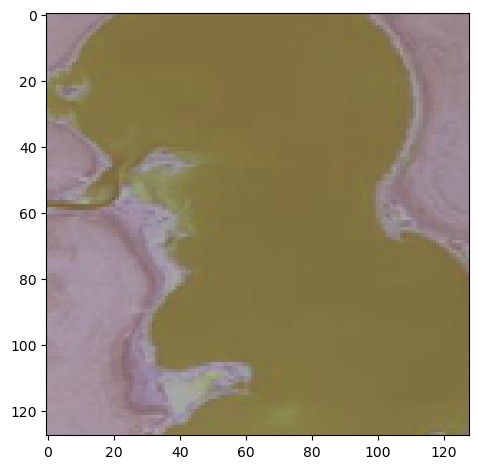

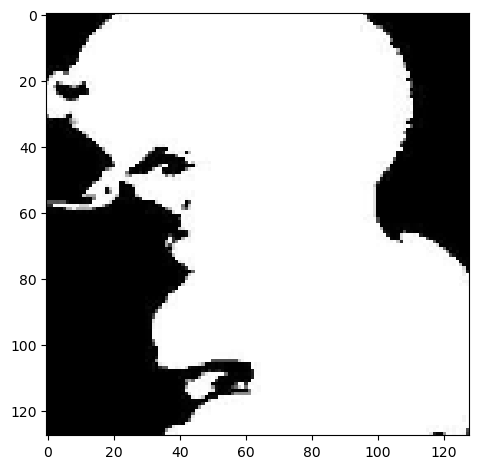

0.21568627450980393 0.7058823529411765
(128, 128, 3)
0.0 1.0
(128, 128)


In [11]:
########## Displaying random image from X_train and Y_train ######### 
random_num = random.randint(0,516)
imshow(x[random_num])
plt.show()
imshow(y[random_num])
plt.show() 

test_img = x[random_num]
test_img2 = y[random_num]
print(test_img.min(), test_img.max())
print(test_img.shape)

print(test_img2.min(), test_img2.max())
print(test_img2.shape)

In [12]:
#splitting 
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

## UNet++: A Nested U-Net Architecture

To detect the cloud formation in our image, we need a convolutional neural network. In this section we will write the code build this network or model. The most used architecture for (semantic segmentation) task is U-Net. U-Net++ makes significant improvements on this, and this will be our architecture of choice for this experiment. [This medium article](https://medium.com/@sh.tsang/review-unet-a-nested-u-net-architecture-biomedical-image-segmentation-57be56859b20) explains the differences and improvement's of U-Net++ architecture over U-Net. Furthermore, how the architecture with "deep-supervision" works, a term you will see as a configurable parameter in our model. So the article is a good read if you want to get more knowledge about U-Net++.

![UNet++: A Nested U-Net Architecture](https://miro.medium.com/max/658/1*ExIkm6cImpPgpetFW1kwyQ.png)

The code below has been adopted from this GitHub repo: https://github.com/CarryHJR/Nested-UNet. So a big shoutout to the authors!

In [13]:
# network configuration parameters
# original image is 1600x256, so we will resize it
img_w = 128 # resized weidth
img_h = 128 # resized height
batch_size = 10
epochs = 50
# batch size for training unet
k_size = 3 # kernel size 3x3
val_size = .20 # split of training set between train and validation set
# network hyper parameters
smooth = 1.
dropout_rate = 0.5

In [14]:
def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    act = 'elu'

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x

In [15]:


def Nest_Net(img_rows, img_cols, color_type=3, num_class=1, deep_supervision=False):

    nb_filter = [32,64,128,256,512]
    act = 'elu'

    bn_axis = 3
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')

    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(img_input, [nestnet_output_1,nestnet_output_2,nestnet_output_3,nestnet_output_4])
    else:
        model = Model(img_input, [nestnet_output_4])
    
    return model

In [16]:
model = Nest_Net(img_h, img_w, color_type=3, num_class=1, deep_supervision=False)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv11_1 (Conv2D)              (None, 128, 128, 32  896         ['main_input[0][0]']             
                                )                                                                 
                                                                                                  
 dp11_1 (Dropout)               (None, 128, 128, 32  0           ['conv11_1[0][0]']               
                                )                                                             

                                                                                                  
 dp32_1 (Dropout)               (None, 32, 32, 128)  0           ['conv32_1[0][0]']               
                                                                                                  
 conv22_1 (Conv2D)              (None, 64, 64, 64)   73792       ['merge22[0][0]']                
                                                                                                  
 merge12 (Concatenate)          (None, 128, 128, 64  0           ['up12[0][0]',                   
                                )                                 'dp11_2[0][0]']                 
                                                                                                  
 dp42_2 (Dropout)               (None, 16, 16, 256)  0           ['conv42_2[0][0]']               
                                                                                                  
 conv32_2 

 dp13_2 (Dropout)               (None, 128, 128, 32  0           ['conv13_2[0][0]']               
                                )                                                                 
                                                                                                  
 up14 (Conv2DTranspose)         (None, 128, 128, 32  8224        ['dp23_2[0][0]']                 
                                )                                                                 
                                                                                                  
 conv24_1 (Conv2D)              (None, 64, 64, 64)   147520      ['merge24[0][0]']                
                                                                                                  
 merge14 (Concatenate)          (None, 128, 128, 12  0           ['up14[0][0]',                   
                                8)                                'dp11_2[0][0]',                 
          

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [19]:
x_train.shape

(800, 128, 128, 3)

In [ ]:
history=model.fit(x_train,
          y_train,
          batch_size=5, 
          epochs=60,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/60
160/160 [==============================] - 867s 5s/step - loss: 1.4187 - binary_accuracy: 0.5891 - val_loss: 1.1107 - val_binary_accuracy: 0.6325
Epoch 2/60
160/160 [==============================] - 963s 6s/step - loss: 0.9849 - binary_accuracy: 0.6427 - val_loss: 0.8881 - val_binary_accuracy: 0.6906
Epoch 3/60
160/160 [==============================] - 3036s 19s/step - loss: 0.8325 - binary_accuracy: 0.6536 - val_loss: 0.7343 - val_binary_accuracy: 0.6976
Epoch 4/60
160/160 [==============================] - 1189s 7s/step - loss: 0.7269 - binary_accuracy: 0.6669 - val_loss: 0.6865 - val_binary_accuracy: 0.7007
Epoch 5/60
160/160 [==============================] - 1083s 7s/step - loss: 0.6588 - binary_accuracy: 0.6783 - val_loss: 0.6381 - val_binary_accuracy: 0.6797
Epoch 6/60
 50/160 [========>.....................] - ETA: 1:36:45 - loss: 0.6402 - binary_accuracy: 0.6807

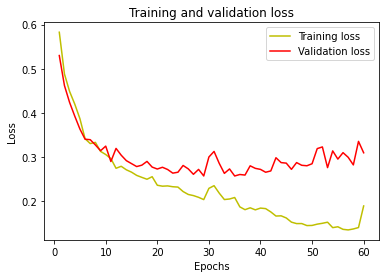

In [19]:
#plot the training and validation loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

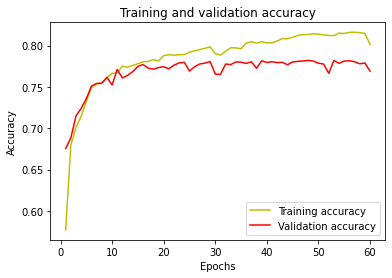

In [20]:
#plot the training and validation accuracy at each epoch
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Original Image: 


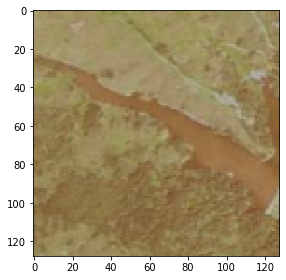

Predicted Mask: 


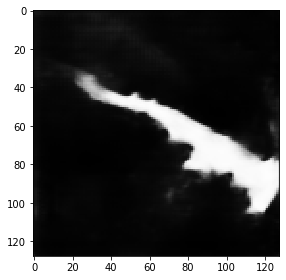

Original Image: 


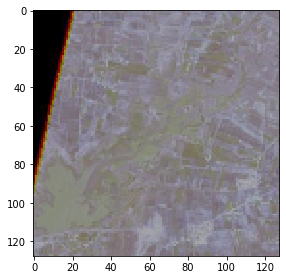

Predicted Mask: 


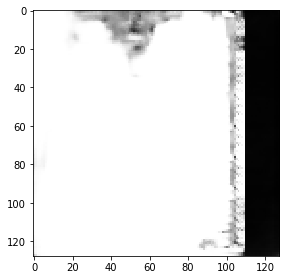

Original Image: 


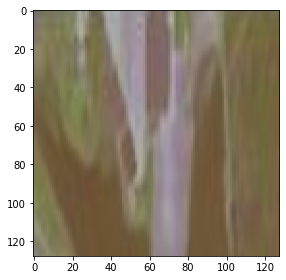

Predicted Mask: 


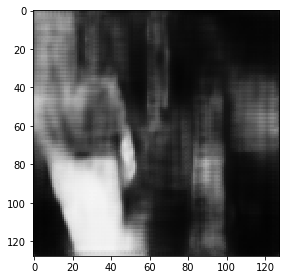

Original Image: 


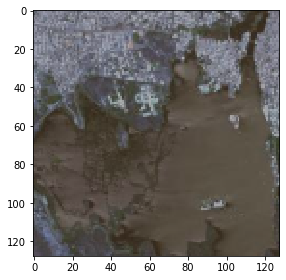

Predicted Mask: 


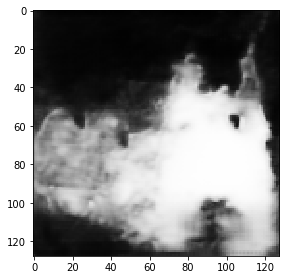

Original Image: 


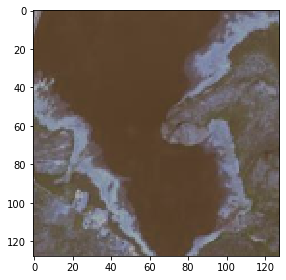

Predicted Mask: 


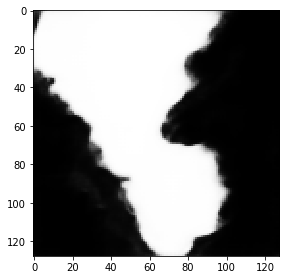

Original Image: 


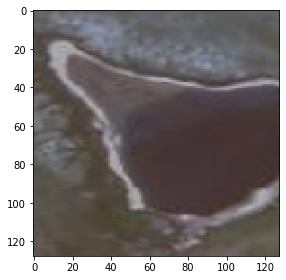

Predicted Mask: 


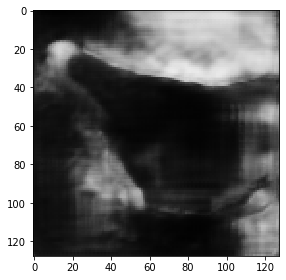

Original Image: 


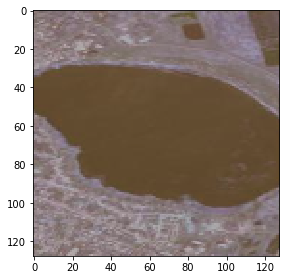

Predicted Mask: 


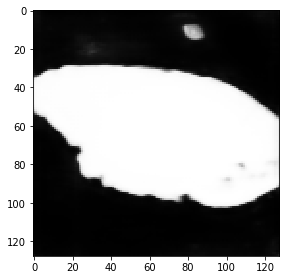

In [26]:
########## Predicting random images from x_val ######### 
for i in range(0,7):    
    random_num = random.randint(0,500)
    original_image = x_val[random_num]
    imshow(original_image)
    print("Original Image: ")
    plt.show()

    original_image=np.expand_dims(original_image,axis=0)
    predicted_mask = model.predict(original_image)
    predicted_mask = predicted_mask.reshape(mask.shape)
    print("Predicted Mask: ")
    imshow(predicted_mask,cmap='gray')
    plt.show()
    i+=1

In [22]:
model.save("satellite_unet.hdf5")